In [2]:
import torch
import torch.nn as nn
from stabnode.node import MLP
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from data.budworm import simulate_trials
from sklearn.preprocessing import MinMaxScaler

In [19]:
# x = np.linspace(0,1,101)

## Generate more interesting data
k = 8.5

xs = []
ts = []
x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

In [20]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

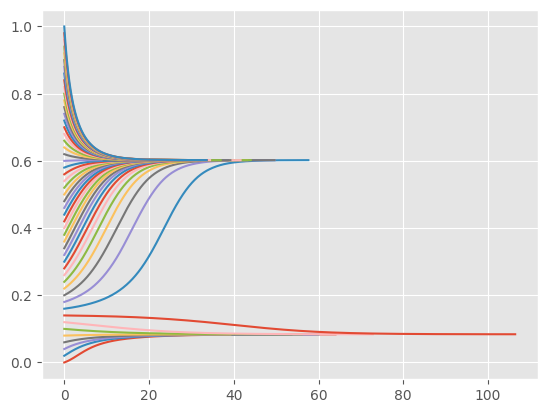

In [21]:
for tsi,xi in zip(ts,xs_scaled):
    plt.plot(tsi,xi)

In [6]:
x = xs_scaled[-1]

In [7]:
from data.budworm import g_true, f_true

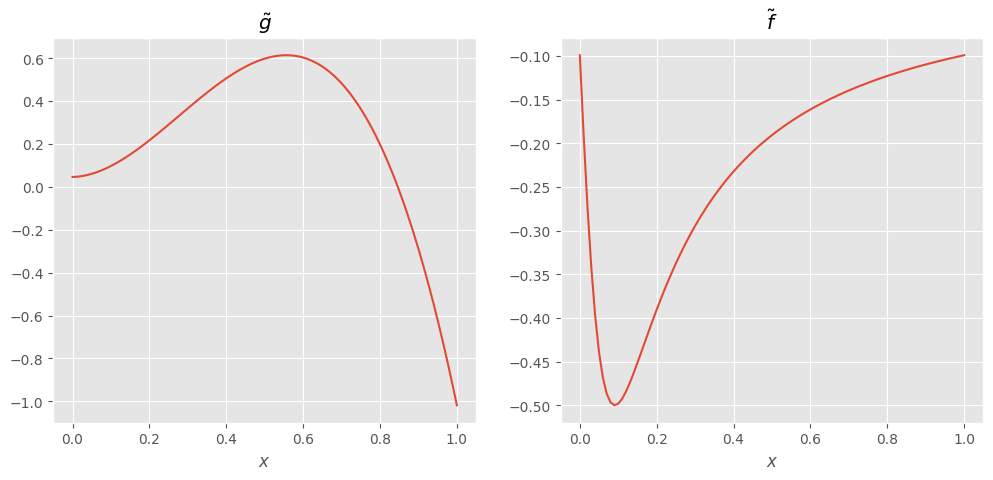

In [8]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).reshape(-1)

f_true_arr = f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).reshape(-1)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x_lin, g_true_arr)
ax1.set_title(r"$\tilde{g}$")
ax1.set_xlabel(r"$x$")
ax2.plot(x_lin, f_true_arr)
ax2.set_title(r"$\tilde{f}$")
ax2.set_xlabel(r"$x$")
plt.show()

## Try Learning Polynomial Approximation with Feature library regression?


$$
\dot x = rx (1-x/k) - \frac{x^2}{1+x^2}
$$

$$
g = \frac{r}{k}(1+x^2)(k-x) \quad \text{and} \quad f = -\frac{x}{1+x^2}
$$

$$
g(x,k)=-\frac{r}{k}x^3 + rx^2 -\frac{r}{k}x +r 
$$

$$
f'(x) = \frac{x^2 - 1}{(1+x^2)^2}
$$

$$
f''(x) = -\frac{2x(x^2 - 3)}{(1+x^2)^3}
$$

$$
f^{(3)}(x) = \frac{6(x^4 - 6x^2 + 1)}{(1+x^2)^4}
$$

$$
f^{(4)}(x) = -\frac{24x(x^4 - 10x^2 + 5)}{(1+x^2)^5}
$$

$$
f^{(5)}(x) = \frac{120(x^6 - 15x^4 + 15x^2 - 1)}{(1+x^2)^6}
$$


$$
\mathcal{P}(f) = f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2 + \frac{1}{3!} \mathcal{O}(x-x_0)^3
$$

In [9]:
import sympy as sp
import numpy as np

def taylor_polynomial_function(f, x, x0, N):
    """
    Return a callable Python function representing the truncated Taylor
    expansion of f(x) around x0 up to order N.
    
    f  : sympy expression
    x  : sympy symbol (variable)
    x0 : center of expansion (numeric)
    N  : order of expansion (max power of (x-x0))
    """
    # Generate Taylor polynomial (SymPy expression)
    poly = sp.series(f, x, x0, N+1).removeO()
    
    # Convert to a fast numerical function
    poly_func = sp.lambdify(x, poly, "numpy")
    
    return poly, poly_func


# --------------------------
# Example usage
# --------------------------

# Define variable and function
x = sp.symbols('x')
f = -x / (1 + x**2)

# Expansion center and order
x0 = 5  # center point
N = 30      # order

# Get Taylor polynomial and callable
poly_expr, poly_func = taylor_polynomial_function(f, x, x0, N)

print("Taylor polynomial around x0=1 up to order 5:")
print(poly_expr)

# Evaluate at some test points
points = [0.8, 1.0, 1.2, 1.5]
print("\nEvaluations of polynomial approximation:")
for p in points:
    print(f"P({p}) = {poly_func(p):.6f},   f({p}) = {float(f.subs(x, p)):.6f}")


Taylor polynomial around x0=1 up to order 5:
6*x/169 - 257499110199672665*(x - 5)**30/2232152448529156308005497643127907090432 + 11970224587477467*(x - 5)**29/21463004312780349115437477337768337408 - 17023836407648155*(x - 5)**28/6604001327009338189365377642390257664 + 2864483360640839*(x - 5)**27/254000051038820699590976063168856064 - 893922861443095*(x - 5)**26/19538465464524669199305851012988928 + 30867902818743*(x - 5)**25/187869860235814126916402413586432 - 26214865485125*(x - 5)**24/57806110841788962128123819565056 + 584824319281*(x - 5)**23/2223311955453421620312454598656 + 1566663253255*(x - 5)**22/171023996573340124639419584512 - 161887318953*(x - 5)**21/1644461505512885813840572928 + 377602269605*(x - 5)**20/505988155542426404258637824 - 95420159401*(x - 5)**19/19461082905477938625332224 + 44353794185*(x - 5)**18/1497006377344456817333248 - 2429784837*(x - 5)**17/14394292089850546320512 + 4064430715*(x - 5)**16/4429012950723245021696 - 815616479*(x - 5)**15/170346651950894039

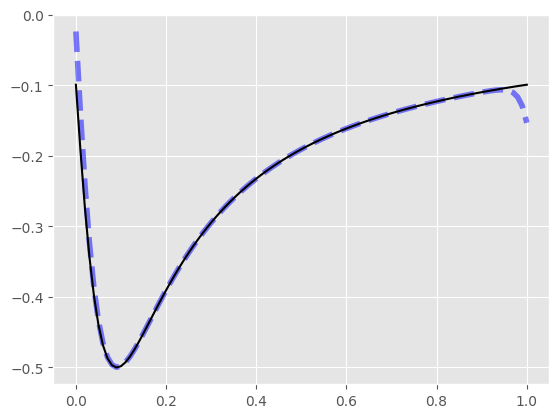

In [10]:
plt.plot(x_lin, poly_func(x_lin_unscaled), linestyle='--', color='blue', alpha=0.5, lw=4)
plt.plot(x_lin, f_true_arr, c='black')
plt.show()

In [11]:
poly_expr

6*x/169 - 257499110199672665*(x - 5)**30/2232152448529156308005497643127907090432 + 11970224587477467*(x - 5)**29/21463004312780349115437477337768337408 - 17023836407648155*(x - 5)**28/6604001327009338189365377642390257664 + 2864483360640839*(x - 5)**27/254000051038820699590976063168856064 - 893922861443095*(x - 5)**26/19538465464524669199305851012988928 + 30867902818743*(x - 5)**25/187869860235814126916402413586432 - 26214865485125*(x - 5)**24/57806110841788962128123819565056 + 584824319281*(x - 5)**23/2223311955453421620312454598656 + 1566663253255*(x - 5)**22/171023996573340124639419584512 - 161887318953*(x - 5)**21/1644461505512885813840572928 + 377602269605*(x - 5)**20/505988155542426404258637824 - 95420159401*(x - 5)**19/19461082905477938625332224 + 44353794185*(x - 5)**18/1497006377344456817333248 - 2429784837*(x - 5)**17/14394292089850546320512 + 4064430715*(x - 5)**16/4429012950723245021696 - 815616479*(x - 5)**15/170346651950894039296 + 314748775*(x - 5)**14/13103588611607233

## Look at time to steady as a relation to the values of $f$

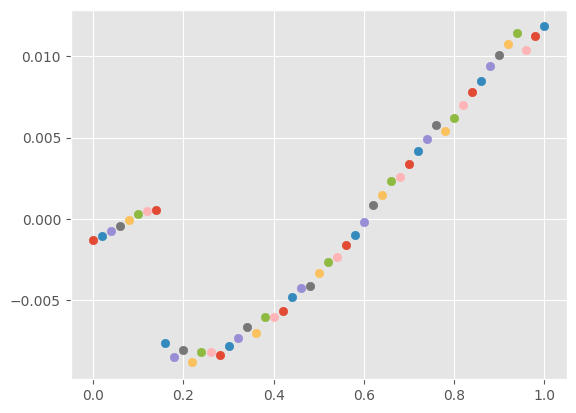

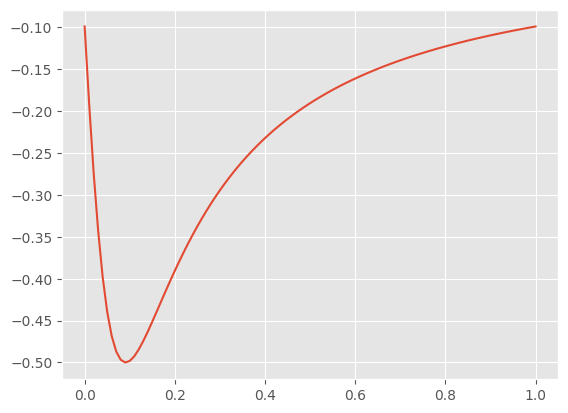

In [12]:
for tsi, xi in zip(ts, xs_scaled):
    dxdt = (xi[-1] - xi[0]) / (tsi[-1]-tsi[0])
    plt.scatter(xi[0], -dxdt)
# plt.plot(x_lin, f_true_arr)
plt.show()
plt.plot(x_lin, f_true_arr)

## Try trimming experiments so they end right at steady state observation

In [13]:
from data.budworm import budworm_steady_states
steady_states = budworm_steady_states(k,r=0.56)
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(k,r=0.56)).reshape(-1,1)).reshape(-1)

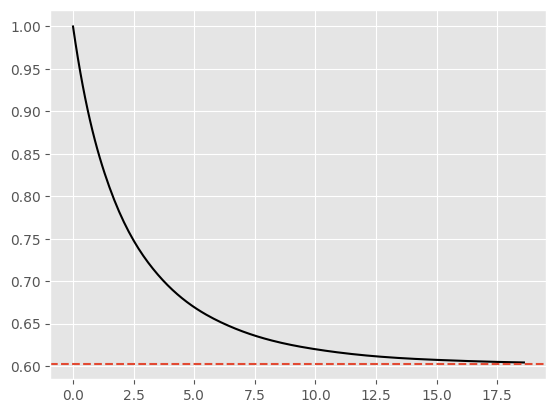

In [14]:
trial = 50
cutoff = -150
plt.plot(ts[trial][:cutoff], xs_scaled[trial][:cutoff],c='black')
if trial < 8:
    plt.axhline(scaled_steady_states[0], linestyle='--')
else:
    plt.axhline(scaled_steady_states[-1], linestyle='--')

In [15]:
cutoffs = [
    -200, 
    -200,
    -200,
    -150,
    -1,
    -1, # trial 5
    -100,
    -200,
    -150,
    -150, # trial 9,
    -200,
    -150,
    -180,
    -150,
    -130,
    -130,
    -130,
    -150,
    -120,
    -120,
    -120,
    -120, # trial 21
    -120,
    -120,
    -100,
    -100,
    -100,
    -80,
    -80, # trial 28,
    -1,
    -1,
    -1,
    -70,
    -70,
    -100,
    -100, # trial 35
    -100,
    -100,
    -100,
    -150,
    -150, # 40
    -150,
    -150,
    -150,
    -100,
    -120,
    -120,
    -120,
    -150,
    -150,
    -150, # 50
]

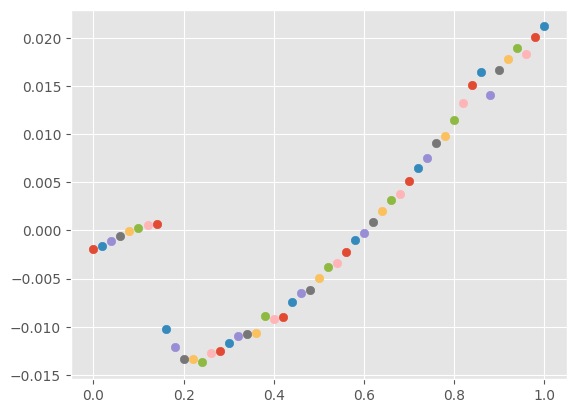

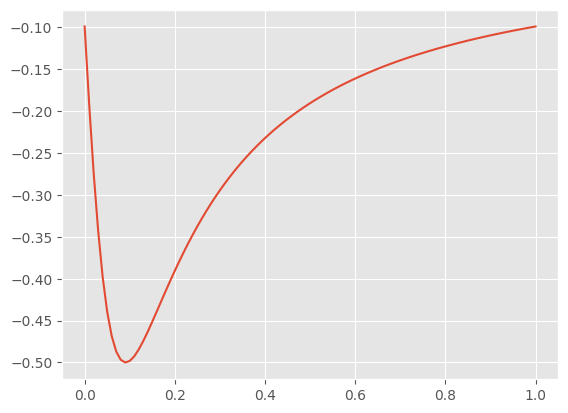

In [16]:
for idx,(tsi, xi) in enumerate(zip(ts, xs_scaled)):
    last = cutoffs[idx]
    dxdt = (xi[last] - xi[0]) / (tsi[last]-tsi[0])
    plt.scatter(xi[0], -(dxdt))
# plt.plot(x_lin, f_true_arr)
plt.show()
plt.plot(x_lin, f_true_arr)

## Learn more trajectories

In [211]:
# x = np.linspace(0,1,101)

## Generate more interesting data
k = 8.5

xs = []
ts = []
x0s = np.linspace(0.1,10,101)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

In [212]:
xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

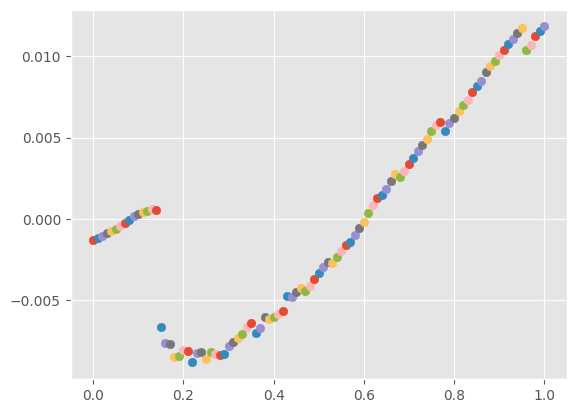

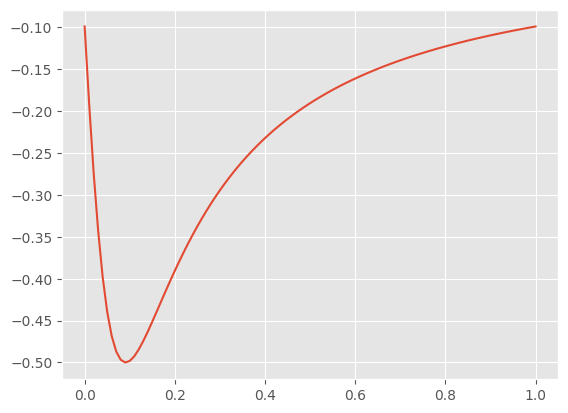

In [213]:
for tsi, xi in zip(ts, xs_scaled):
    dxdt = (xi[-1] - xi[0]) / (tsi[-1]-tsi[0])
    plt.scatter(xi[0], -dxdt)
# plt.plot(x_lin, f_true_arr)
plt.show()
plt.plot(x_lin, f_true_arr)

## Approximate $\tilde f$

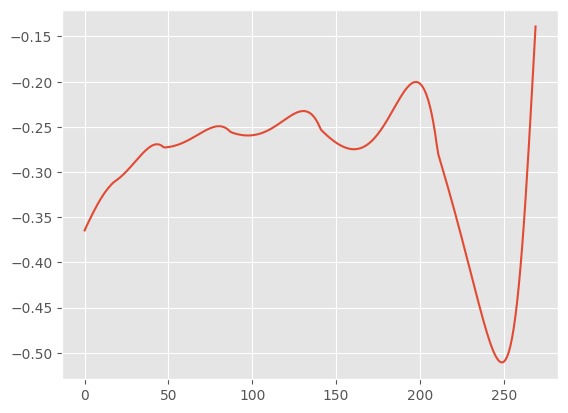

In [91]:
trial = 40
cutoff=-50
xs_scaled[trial].shape
xi = xs_scaled[trial]
ti = ts[trial]

dxdt = (xi[1:] - xi[:-1]) / (ti[1:] - ti[:-1])
x_star = xi[-1]
f_vec = dxdt / (xi[:-1]-x_star)

plt.plot(f_vec[:cutoff])

In [95]:
cutoff = -1
f_vecs = []
f_approx = []
for ti, xi in zip(ts,xs_scaled):
    dxdt = (xi[1:] - xi[:-1]) / (ti[1:] - ti[:-1])
    x_star = xi[-1]
    f_vec = dxdt / (xi[:-1]-x_star)
    f_vecs.append(f_vec)
    f_approx.append(np.mean(f_vec[:cutoff]))


In [93]:
min_len = np.inf
for f_vec in f_vecs: 
    if len(f_vec) < min_len:
        min_len = len(f_vec)

In [101]:
len(ts[0]), len(xs_scaled[0]), len(f_vecs[0])

(641, 641, 640)

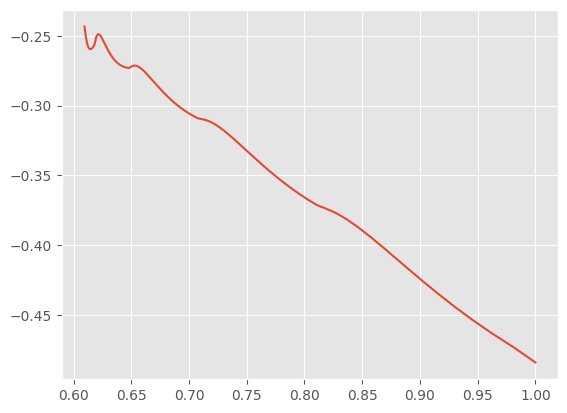

In [143]:
test = 50
cutoff = -200
plt.plot(xs_scaled[test][:cutoff-1], f_vecs[test][:cutoff])
plt.show()

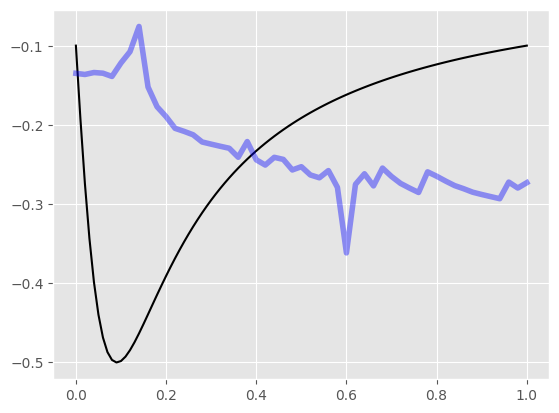

In [74]:
plt.plot(x_lin, f_true_arr, c='black')
plt.plot(x_lin[::2], f_approx, c='blue', alpha=0.4, lw=4)

# Lyapunov functions

In [45]:
np.mean(f_aprox[0:10])

-0.06641753078609716

In [39]:
f_true_arr[0]

-0.09900990099009901

In [75]:
ti[1:]-ti[:-1]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.